In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras import regularizers


from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.utils import load_img

from tqdm.notebook import tqdm
from keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image

2024-04-05 18:23:36.091479: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 18:23:36.091637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 18:23:36.271425: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Age Classification Convolutional Neural Network

## Overview
We will build two neural networks to classify age, gender.

### Age Classification
The first neural network will classify age into the following bins:

- <span style="color:blue">Age 1-2</span>
- <span style="color:green">Age 3-9</span>
- <span style="color:orange">Age 10-20</span>
- <span style="color:red">Age 21-27</span>
- <span style="color:">Age 28-45</span>
- <span style="color:purple">Age 46-65</span>
- <span style="color:yellow">Age +66</span>




# Data Import

## Dataset Selection
We will use the augmented open-source dataset called <span style="color:blue">"UTKFace"</span>. This dataset comprises over <span style="color:green">200,000 images</span> of individuals ranging from <span style="color:orange">1 to 100 years</span> of age.


In [2]:
BASE_DIR_train ="/kaggle/input/augmented-age-dataset/augmented_age_dataset/content/combined_faces_train_augmented/"

BASE_DIR_test ="/kaggle/input/age-test-dataset/content/combined_faces/"



In [3]:
age_classes=['1-2','3-9','10-20','21-27','28-45','46-65','+66']



In [4]:
image_paths_train = []
age_labels_train = []

for filename in tqdm(os.listdir(BASE_DIR_train)):
    image_path = os.path.join(BASE_DIR_train, filename)
    temp = filename.split('_')
    age = int(temp[0])
    image_paths_train.append(image_path)
    age_labels_train.append(age)


  0%|          | 0/234400 [00:00<?, ?it/s]

In [5]:
image_paths_test = []
age_labels_test = []

for filename in tqdm(os.listdir(BASE_DIR_test)):
    image_path = os.path.join(BASE_DIR_test, filename)
    temp = filename.split('_')
    age = int(temp[0])
    image_paths_test.append(image_path)
    age_labels_test.append(age)


  0%|          | 0/33486 [00:00<?, ?it/s]

In [6]:
df_age_train = pd.DataFrame()
df_age_train['image'], df_age_train['age'] = image_paths_train, age_labels_train
df_age_train.head()

,image,age
0,/kaggle/input/augmented-age-dataset/augmented_...,8
1,/kaggle/input/augmented-age-dataset/augmented_...,17
2,/kaggle/input/augmented-age-dataset/augmented_...,31
3,/kaggle/input/augmented-age-dataset/augmented_...,78
4,/kaggle/input/augmented-age-dataset/augmented_...,90


In [7]:
df_age_test = pd.DataFrame()
df_age_test['image'], df_age_test['age'] = image_paths_test, age_labels_test
df_age_test.head()

,image,age
0,/kaggle/input/age-test-dataset/content/combine...,8
1,/kaggle/input/age-test-dataset/content/combine...,30
2,/kaggle/input/age-test-dataset/content/combine...,20
3,/kaggle/input/age-test-dataset/content/combine...,3
4,/kaggle/input/age-test-dataset/content/combine...,23


# Age Binning
We will transform the ages into <span style="color:blue">bins</span> for better classification
.

## Data Validation

### Results
The results were successful. We managed to import our data and store it into our variables.
riables.


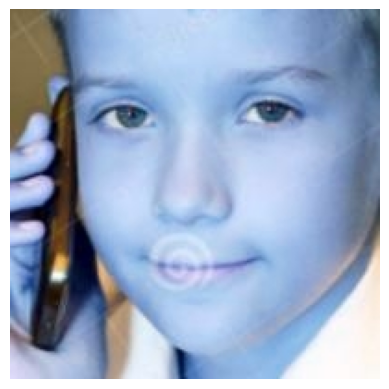

In [8]:
img = Image.open(df_age_train['image'][0])
plt.axis('off')
plt.imshow(img);

In [9]:
img=cv2.imread(df_age_train['image'][0])
img.shape

(200, 200, 3)

In [10]:
def age_bins(age):

    if 1 <= age <= 2:
        return '1-2'
    elif 3 <= age <= 9:
        return '3-9'
    elif 10 <= age <= 20:
        return '10-20'
    elif 21 <= age <= 27:
        return '21-27'
    elif 28 <= age <= 45:
        return '28-45'
    elif 46 <= age <= 65:
        return '46-65'
    else:
        return '+66'

In [11]:
def age_bins_encoded(age):

    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6


In [12]:
df_age_train['age_bins']=df_age_train['age'].apply(age_bins)
df_age_test['age_bins']=df_age_test['age'].apply(age_bins)

In [13]:
df_age_train['age_enc']=df_age_train['age'].apply(age_bins_encoded)
df_age_test['age_enc']=df_age_test['age'].apply(age_bins_encoded)

In [14]:
df_age_train

,image,age,age_bins,age_enc
0,/kaggle/input/augmented-age-dataset/augmented_...,8,3-9,1
1,/kaggle/input/augmented-age-dataset/augmented_...,17,10-20,2
2,/kaggle/input/augmented-age-dataset/augmented_...,31,28-45,4
3,/kaggle/input/augmented-age-dataset/augmented_...,78,+66,6
4,/kaggle/input/augmented-age-dataset/augmented_...,90,+66,6
...,...,...,...,...
234395,/kaggle/input/augmented-age-dataset/augmented_...,85,+66,6
234396,/kaggle/input/augmented-age-dataset/augmented_...,63,46-65,5
234397,/kaggle/input/augmented-age-dataset/augmented_...,59,46-65,5
234398,/kaggle/input/augmented-age-dataset/augmented_...,1,1-2,0


In [15]:
df_age_test

,image,age,age_bins,age_enc
0,/kaggle/input/age-test-dataset/content/combine...,8,3-9,1
1,/kaggle/input/age-test-dataset/content/combine...,30,28-45,4
2,/kaggle/input/age-test-dataset/content/combine...,20,10-20,2
3,/kaggle/input/age-test-dataset/content/combine...,3,3-9,1
4,/kaggle/input/age-test-dataset/content/combine...,23,21-27,3
...,...,...,...,...
33481,/kaggle/input/age-test-dataset/content/combine...,37,28-45,4
33482,/kaggle/input/age-test-dataset/content/combine...,27,21-27,3
33483,/kaggle/input/age-test-dataset/content/combine...,35,28-45,4
33484,/kaggle/input/age-test-dataset/content/combine...,7,3-9,1


# Data Visualization

### File Information Extraction
To kickstart our data visualization process, we'll import the filenames into a dataframe.Extracting the details encapsulated within the filenames, including <span style="color:blue">name</span>, <span style="color:green">age</span>.





### Age Distribution (Training Dataset)

- **28-45:** <span style="color:green">65,490 instances</span>
- **21-27:** <span style="color:blue">46,840 instances</span>
- **46-65:** <span style="color:red">39,190 instances</span>
- **1-2:** <span style="color:orange">22,340 instances</span>
- **10-20:** <span style="color:purple">21,950 instances</span>
- **3-9:** <span style="color:green">19,710 instances</span>
- **+66:** <span style="color:pink">18,880 instances</span>

The dataset showcases a diverse age distribution. The largest representation is observed in the age range of 28-45, followed by 21-27 and 46-65. Notably, there's a substantial presence of individuals aged 1-2 and 10-20, indicating a significant representation of younger age groups. The dataset also includes a considerable number of instances in the 3-9 age range. Additionally, there's a noticeable representation of individuals aged 66 and above.

Overall, the dataset demonstrates diversity in age representation, encompassing a wide range of age groups. However, the predominance of younger age groups may impact model performance and generalization, particularly in age-related predictions or analyses.


### Age Distribution (Test Dataset)

- **28-45:** <span style="color:green">9,356 instances</span>
- **21-27:** <span style="color:blue">6,691 instances</span>
- **46-65:** <span style="color:red">5,598 instances</span>
- **1-2:** <span style="color:orange">3,192 instances</span>
- **10-20:** <span style="color:purple">3,136 instances</span>
- **3-9:** <span style="color:green">2,816 instances</span>
- **+66:** <span style="color:pink">2,697 instances</span>

The test dataset exhibits a similar age distribution pattern to the training dataset, with the highest representation in the 28-45 and 21-27 age groups. However, the test dataset contains substantially fewer instances across all age bins compared to the training dataset. This difference in data volume and distribution between the training and test datasets may impact model evaluation and generalization.

The skew towards younger age groups, particularly 28-45 and 21-27, in both datasets may influence model performance and generalization. It's crucial to consider this distribution during model evaluation to ensure robust performance across all age categories.



In [16]:
df_age_train['age_bins'].value_counts()

age_bins
28-45    65490
21-27    46840
46-65    39190
1-2      22340
10-20    21950
3-9      19710
+66      18880
Name: count, dtype: int64

In [17]:
df_age_test['age_bins'].value_counts()

age_bins
28-45    9356
21-27    6691
46-65    5598
1-2      3192
10-20    3136
3-9      2816
+66      2697
Name: count, dtype: int64

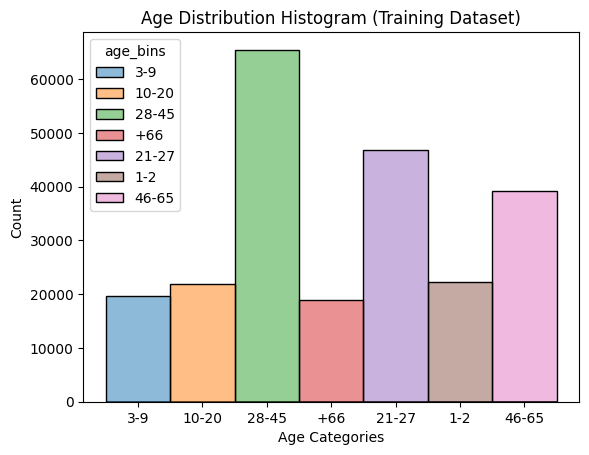

(None,)

In [21]:
import warnings
warnings.filterwarnings("ignore")

sns.histplot(x=df_age_train['age_bins'], hue='age_bins', data=df_age_train)
plt.title('Age Distribution Histogram (Training Dataset)')
plt.xlabel('Age Categories')
plt.show(),

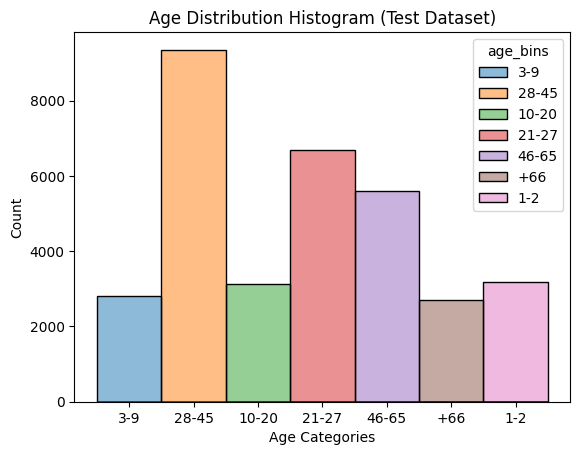

(None,)

In [20]:
sns.histplot(x=df_age_test['age_bins'], hue='age_bins', data=df_age_test)
plt.title('Age Distribution Histogram (Test Dataset)')
plt.xlabel('Age Categories')
plt.show(),

## Data Preparation and Dataframe Creation

### Loading and Preprocessing
- **train_image_list**: <span style="color:blue">Training</span> image file paths.
- **train_labels_list**: <span style="color:blue">Training</span> age labels.
- **test_image_list**: <span style="color:orange">Test</span> image file paths.
- **test_labels_list**: <span style="color:orange">Test</span> age labels.
- **train_image_list_tf**: <span style="color:blue">Training</span> image file paths (TensorFlow constant).
- **train_labels_list_tf**: <span style="color:blue">Training</span> age labels (TensorFlow constant).
- **test_image_list_tf**: <span style="color:orange">Test</span> image file paths (TensorFlow constant).
- **test_labels_list_tf**: <span style="color:orange">Test</span> age labels (TensorFlow constant).
- **num_classes**: <span style="color:green">Number</span> of age categories (7).

### Parsing Function
- **_parse_function(filename, label)**: Parses images and labels.
    - Reads image files.
    - Decodes JPEG images.
    - Converts labels to one-hot encoded vectors.


In [18]:
train_image_list = list(df_age_train['image'])
train_labels_list = list(df_age_train['age_enc'])

test_image_list = list(df_age_test['image'])
test_labels_list = list(df_age_test['age_enc'])

In [19]:
train_image_list_tf = tf.constant(train_image_list)
train_labels_list_tf = tf.constant(train_labels_list)

test_image_list_tf = tf.constant(test_image_list)
test_labels_list_tf = tf.constant(test_labels_list)

In [20]:
num_classes = 7
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)  
    
    image_resized = tf.image.resize(image_decoded, [200,200])
    
    image_normalized = image_resized / 255.0

    
    label = tf.one_hot(label, num_classes)

    return image_normalized, label

In [21]:

train_image_dataset = tf.data.Dataset.from_tensor_slices((train_image_list_tf, train_labels_list_tf))
train_image_dataset = train_image_dataset.map(_parse_function)
train_image_dataset = train_image_dataset.batch(312) 


test_image_dataset = tf.data.Dataset.from_tensor_slices((test_image_list_tf, test_labels_list_tf))
test_image_dataset = test_image_dataset.map(_parse_function)
test_image_dataset = test_image_dataset.batch(312) 

In [23]:
train_image_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 200, 200, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

# Age Classification Model

## Model Architecture

The age classification model is a Convolutional Neural Network (CNN) with several convolutional layers followed by max-pooling layers for feature extraction. Batch normalization is applied after each convolutional layer for normalization and faster training. Dropout regularization is also used to prevent overfitting.

After the convolutional layers, a Global Average Pooling layer is added to reduce the spatial dimensions of the feature maps. Two dense layers with ReLU activation functions are then applied for further feature processing.

The output layer employs a <span style="color:orange">softmax activation function</span> to predict the probability distribution across the age categories.

Model Summary:
- Input Shape: (Image Height, Image Width, 3)
- Convolutional Layers: <span style="color:blue">64, 128, 256, and 512 filters</span> with a kernel size of (3, 3)
- Max Pooling Layers: Applied after each convolutional layer
- Dropout Layer: Applied with a dropout rate of <span style="color:green">0.3</span> after the last convolutional layer
- Global Average Pooling Layer
- Dense Layers: <span style="color:blue">256 and 128 units</span> with ReLU activation function
- Batch Normalization: Applied after dense layers
- Output Layer: Dense layer with <span style="color:blue">7 units</span> and softmax activation function for age classification

The model architecture effectively extracts features from input images and classifies them into different age categories.


## Compilation
The model is compiled using the <span style="color:blue">Adam</span> with a learning rate of <span style="color:green">0.001</span>. <span style="color:orange">Categorical cross-entropy loss</span> is utilized as the loss function, which is suitable for multi-class classification tasks.

## Model Training
Training is conducted using a batch size of <span style="color:green">312</span> over <span style="color:green">30</span> epochs. <span style="color:orange">Early stopping</span> with a patience of <span style="color:green">5</span> is employed to prevent overfitting, and the best model weights are restored. The training and validation data are evaluated for accuracy metrics.

## Results

The age classification model was trained over 30 epochs, yielding the following insights:

- **Initial Epoch:**
  - The model commenced with an accuracy of <span style="color:orange">51.07%</span> and a loss of <span style="color:orange">1.1936</span>, indicating modest performance.

- **Progressive Improvement:**
  - Subsequent epochs demonstrated consistent enhancements in both accuracy and loss metrics, reflecting improved model learning.

- **Final Epoch:**
  - By the 30th epoch, the model achieved a notable accuracy of <span style="color:green">96.28%</span> with a reduced loss of <span style="color:green">0.1024</span>.

- **Validation Performance:**
  - The validation metrics exhibited fluctuations throughout training, with accuracy ranging from <span style="color:green">43.32%</span> to <span style="color:green">81.57%</span>, and loss varying between <span style="color:green">0.7069</span> and <span style="color:green">2.2826</span>.

These observations suggest progressive improvement in model performance over the training epochs, culminating in satisfactory accuracy and loss metrics by the final epoch. However, fluctuations in validation performance indicate potential challenges in generalization to unseen data.


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


model = tf.keras.models.Sequential()


model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(200,200,1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))


model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())


model.add(layers.Dense(7, activation='softmax'))  


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 198, 198, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 97, 97, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 46, 46, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 21, 21, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 10, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,719,303 (6.56 MB)

 Trainable params: 1,717,127 (6.55 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [25]:


early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)


#Callbacks
callbacks_list=[early_stopping_callback]

model.compile(optimizer="adam", loss=['categorical_crossentropy'], metrics=['accuracy'])


                

In [26]:

history=model.fit(
    train_image_dataset,
    batch_size=312,    
    epochs=30,
    callbacks=callbacks_list,
    validation_data=test_image_dataset,
    verbose=2,
    shuffle=False


)


Epoch 1/30



I0000 00:00:1712288876.308812      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


752/752 - 980s - 1s/step - accuracy: 0.5107 - loss: 1.1936 - val_accuracy: 0.5321 - val_loss: 1.0949

Epoch 2/30

752/752 - 726s - 965ms/step - accuracy: 0.6260 - loss: 0.8829 - val_accuracy: 0.4664 - val_loss: 1.3574

Epoch 3/30

752/752 - 740s - 984ms/step - accuracy: 0.6760 - loss: 0.7605 - val_accuracy: 0.5428 - val_loss: 1.1374

Epoch 4/30

752/752 - 721s - 959ms/step - accuracy: 0.7227 - loss: 0.6581 - val_accuracy: 0.6563 - val_loss: 0.8299

Epoch 5/30

752/752 - 740s - 984ms/step - accuracy: 0.7683 - loss: 0.5565 - val_accuracy: 0.6399 - val_loss: 0.9548

Epoch 6/30

752/752 - 717s - 954ms/step - accuracy: 0.8093 - loss: 0.4638 - val_accuracy: 0.4332 - val_loss: 2.2826

Epoch 7/30

752/752 - 744s - 989ms/step - accuracy: 0.8457 - loss: 0.3818 - val_accuracy: 0.7464 - val_loss: 0.7069

Epoch 8/30

752/752 - 739s - 982ms/step - accuracy: 0.8746 - loss: 0.3164 - val_accuracy: 0.7131 - val_loss: 0.8325

Epoch 9/30

752/752 - 715s - 951ms/step - accuracy: 0.8967 - loss: 0.2625 - val

# Results Visualization

In [27]:
y_predict = model.predict(test_image_dataset)


In [28]:
def argmax_fun(array):
   array_1=[]
   for i in array:
       if i == array.max():
            i=1
       else:
            i=0
       array_1.append(i)
   return array_1

In [29]:
y_predict_argmax= y_predict.copy()
for i in range(len(y_predict)):
    y_predict_argmax[i]= argmax_fun(y_predict[i])

In [30]:
y_predict_argmax

In [31]:
y_val_list=[]
for i in y_age_val:
    y_val_list.append(i.argmax())

In [32]:
cm_age = tf.math.confusion_matrix(labels=list(df_age_test['age_enc']), predictions=y_predict_argmax_list, num_classes=4)
conf_matrix_result = cm_age.numpy()
cm_age= sns.heatmap(cm_age, annot=True, fmt=".1f")
tick_positions = np.arange(4) + 0.5
cm_age.set_yticks(tick_positions, age_classes)

cm_age.set_xticks(tick_positions, age_classes)



## Interpretation of Confusion Matrix

The confusion matrix provides a visual representation of the model's performance in classifying age categories. Here's an interpretation based on the results:

- **<span style="color:green">High Correct Classifications (True Positives)</span>**: The diagonal elements of the confusion matrix indicate the number of instances correctly classified for each age category. For example, the model correctly classified 7013 instances as belonging to the first age category (20-27 years old).

- **<span style="color:red">Misclassifications (False Positives)</span>**: Off-diagonal elements represent instances that were incorrectly classified as belonging to a different age category. For instance, there were 68 instances classified as belonging to the second age category (20-27 years old) but actually belonged to the first category.

- **<span style="color:blue">Results</span>**: By examining the distribution of correct and incorrect classifications across age categories, we can identify any notable patterns or trends. For example, people aged between 20 and 27 have a high chance of being labeled as a person between the age of 28 and 45. 



In [33]:
conf_matrix_result


### Interpretation of Training and Validation Metrics

#### Loss Plot:
- The training loss starts at a value of <span style="color:orange">1.1936</span> in the first epoch and steadily decreases with each epoch.
- Validation loss fluctuates initially but stabilizes around <span style="color:green">0.8299</span> in the fourth epoch.
- Both training and validation loss show a decreasing trend over epochs, indicating effective learning and generalization.

#### Accuracy Plot:
- The training accuracy begins at <span style="color:orange">51.07%</span> in the first epoch and shows a consistent improvement, reaching <span style="color:green">84.57%</span> in the seventh epoch.
- Validation accuracy fluctuates but demonstrates an increasing trend, peaking at <span style="color:green">77.29%</span> in the eleventh epoch.
- Both training and validation accuracies show signs of convergence to stable values, suggesting the model's ability to accurately classify age categories.


In [34]:
epochs = range(len(history.history["loss"]))
plt.plot(epochs, history.history["loss"], 'blue', label = "loss")
plt.plot(epochs, history.history["val_loss"], 'red', label ="val_loss")
plt.title("Total Loss and Total Validation Loss")
plt.legend()

In [35]:
epochs = range(len(history.history["loss"]))
plt.plot(epochs, history.history["accuracy"], 'blue', label = "accuracy")
plt.plot(epochs, history.history["val_accuracy"], 'red', label ="val_accuracy")
plt.title("Total Accuracy and Total Validation Accuracy")
plt.legend()

In [36]:
model.save('age_model_aug.h5')
